<a href="https://colab.research.google.com/github/Ashraf1292/Thesis-Fake_jobs-/blob/main/New_Version_98_APR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.combine import SMOTETomek
import xgboost as xgb
import shap

# Download necessary NLTK resources properly with error handling
print("Downloading necessary NLTK resources...")
nltk_resources = ['punkt', 'stopwords', 'wordnet']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
        print(f"{resource} already downloaded")
    except LookupError:
        print(f"Downloading {resource}...")
        nltk.download(resource, quiet=True)
        print(f"{resource} download complete")

# Step 1: Data Preprocessing
print("Step 1: Loading and preprocessing data...")

# Load dataset
df = pd.read_csv('fake_job_postings.csv')
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['fraudulent'].value_counts()}")

# Function to preprocess text
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    try:
        # Try NLTK tokenization
        tokens = word_tokenize(text)
    except:
        # Fallback to simple tokenization if NLTK fails
        print("Falling back to simple tokenization.")
        tokens = text.split()

    try:
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    except Exception as e:
        print(f"Error in stopwords or lemmatization: {e}")
        # Return simple processed text if stopwords/lemmatization fails
        return text

    return ' '.join(tokens)

# Merge text fields and preprocess
print("Merging and preprocessing text fields...")
df['combined_text'] = (
    df['company_profile'].fillna('') + ' ' +
    df['description'].fillna('') + ' ' +
    df['requirements'].fillna('')
)

# Apply preprocessing to the combined text
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Remove rows with empty processed text
df = df[df['processed_text'].str.strip() != '']
print(f"Dataset shape after preprocessing: {df.shape}")

# Explore text length distribution
df['text_length'] = df['processed_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='fraudulent', bins=50, alpha=0.7)
plt.title('Text Length Distribution by Class')
plt.xlabel('Processed Text Length')
plt.xlim(0, 10000)  # Adjust limits as needed
plt.savefig('text_length_distribution.png')
plt.close()



Streaming output truncated to the last 5000 lines.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple tokenization.
Falling back to simple t

<ipython-input-6-52ed0da5126e>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['processed_text'].apply(len)


In [7]:
# Step 2: Feature Engineering
print("\nStep 2: Feature Engineering...")

# TF-IDF Vectorization
print("Performing TF-IDF vectorization...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.85
)

X = tfidf_vectorizer.fit_transform(df['processed_text'])
y = df['fraudulent']

print(f"Feature matrix shape: {X.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")



Step 2: Feature Engineering...
Performing TF-IDF vectorization...
Feature matrix shape: (17879, 5000)
Training set: (14303, 5000)
Test set: (3576, 5000)


In [8]:
# Step 3: Handle Class Imbalance
print("\nStep 3: Handling class imbalance...")
print(f"Class distribution before resampling:\n{np.bincount(y_train)}")

smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

print(f"Class distribution after resampling:\n{np.bincount(y_resampled)}")
print(f"Resampled training set: {X_resampled.shape}")


Step 3: Handling class imbalance...
Class distribution before resampling:
[13611   692]
Class distribution after resampling:
[13611 13611]
Resampled training set: (27222, 5000)


In [12]:
# Step 4: Model Training
print("\nStep 4: Training XGBoost model...")

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=1,  # Already balanced with SMOTE-Tomek
    random_state=42,
    eval_metric='auc'
)

# Train the model without optional parameters that might cause issues
try:
    # First attempt with eval_set and early_stopping_rounds
    xgb_model.fit(
        X_resampled, y_resampled,
        eval_set=[(X_test, y_test)],
        verbose=True
    )
except TypeError:
    # If that fails, try the simplest version
    print("Falling back to basic fit method")
    xgb_model.fit(X_resampled, y_resampled)

# The best_iteration attribute might not be available in all versions
try:
    print(f"Best iteration: {xgb_model.best_iteration}")
except AttributeError:
    print("Best iteration information not available")


Step 4: Training XGBoost model...
[0]	validation_0-auc:0.71679
[1]	validation_0-auc:0.83653
[2]	validation_0-auc:0.85526
[3]	validation_0-auc:0.86716
[4]	validation_0-auc:0.87051
[5]	validation_0-auc:0.88119
[6]	validation_0-auc:0.88852
[7]	validation_0-auc:0.89128
[8]	validation_0-auc:0.89281
[9]	validation_0-auc:0.90268
[10]	validation_0-auc:0.90066
[11]	validation_0-auc:0.90290
[12]	validation_0-auc:0.90809
[13]	validation_0-auc:0.91197
[14]	validation_0-auc:0.91462
[15]	validation_0-auc:0.91855
[16]	validation_0-auc:0.92002
[17]	validation_0-auc:0.92381
[18]	validation_0-auc:0.92608
[19]	validation_0-auc:0.92652
[20]	validation_0-auc:0.92682
[21]	validation_0-auc:0.92998
[22]	validation_0-auc:0.93049
[23]	validation_0-auc:0.93110
[24]	validation_0-auc:0.93146
[25]	validation_0-auc:0.93475
[26]	validation_0-auc:0.93602
[27]	validation_0-auc:0.93796
[28]	validation_0-auc:0.93888
[29]	validation_0-auc:0.93983
[30]	validation_0-auc:0.94126
[31]	validation_0-auc:0.94338
[32]	validation

In [13]:
# Step 5: Model Evaluation
print("\nStep 5: Evaluating model performance...")

# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.close()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.close()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('precision_recall_curve.png')
plt.close()



Step 5: Evaluating model performance...

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3403
           1       0.73      0.80      0.76       173

    accuracy                           0.98      3576
   macro avg       0.86      0.89      0.87      3576
weighted avg       0.98      0.98      0.98      3576




Step 6: Analyzing feature importance...


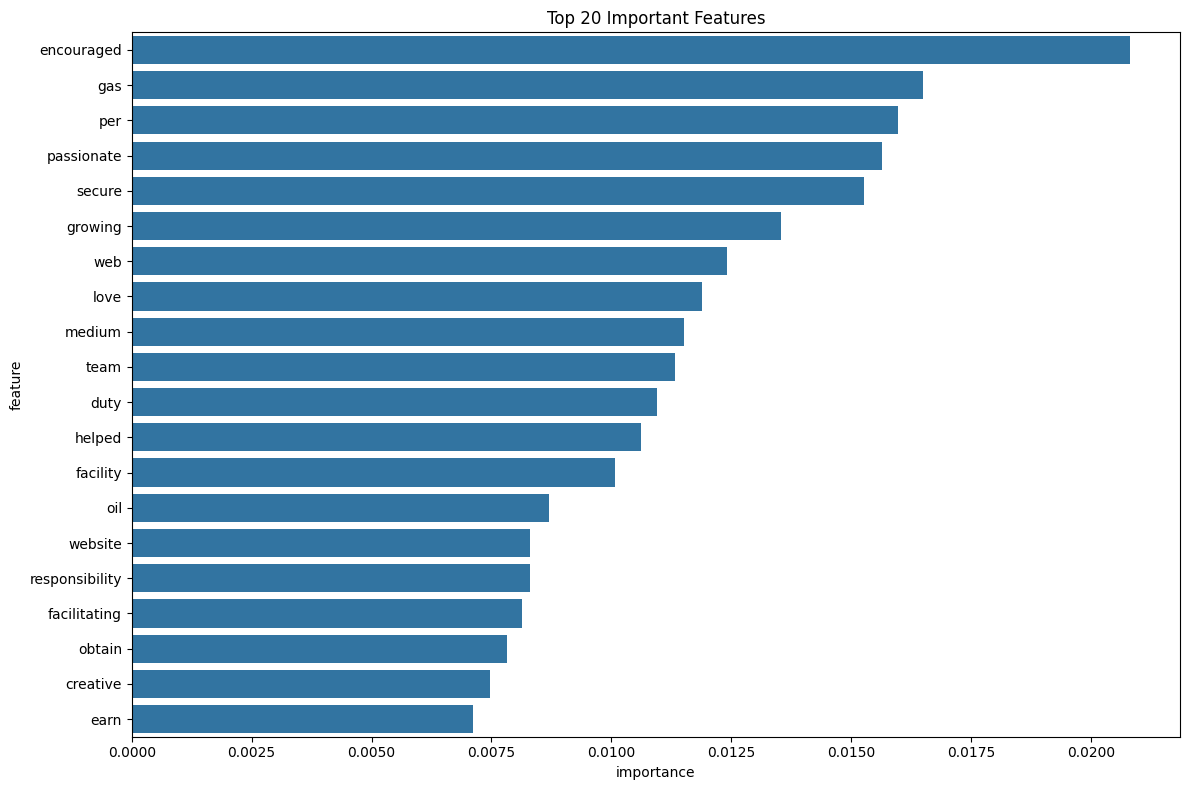

In [15]:
# Step 6: Feature Importance
print("\nStep 6: Analyzing feature importance...")

# Get feature importance from XGBoost
feature_importance = xgb_model.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()  # Add this line to display the plot
# plt.close()  # Comment out or remove this line


Step 7: Performing SHAP analysis...


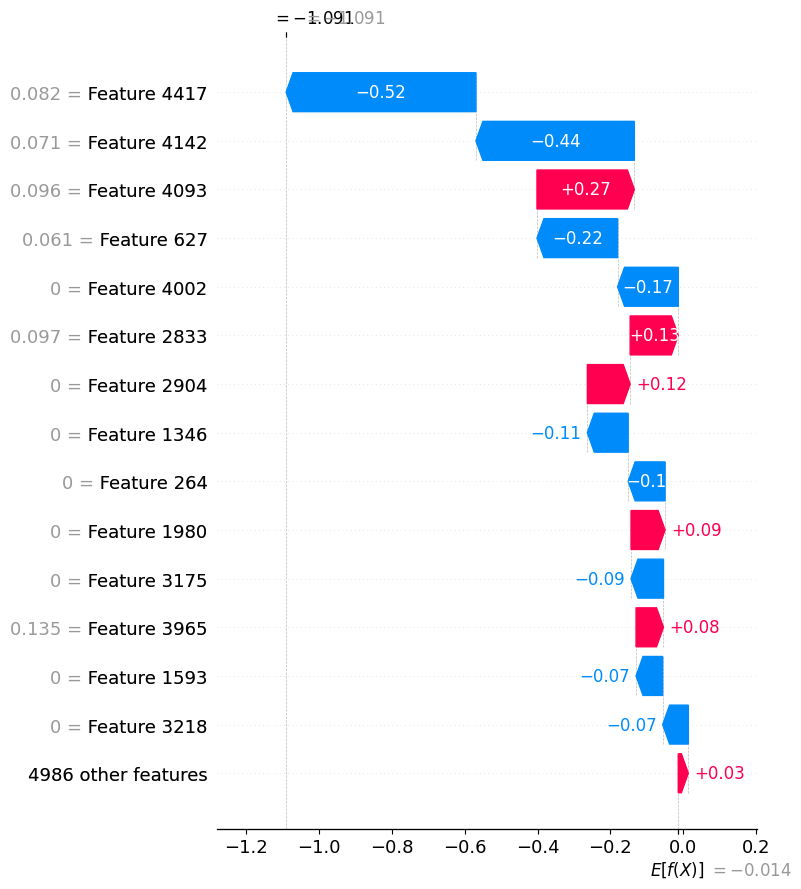


Analysis complete! Check the generated visualizations for insights.


In [17]:
# Step 7: SHAP Analysis
print("\nStep 7: Performing SHAP analysis...")
try:
    # Create explainer and calculate SHAP values
    explainer = shap.Explainer(xgb_model)
    # Taking a subset for SHAP analysis to avoid memory issues
    shap_sample_size = min(500, X_test.shape[0])
    X_test_sample = X_test[:shap_sample_size]
    shap_values = explainer(X_test_sample)

    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig('shap_summary.png')
    plt.close()

    # Waterfall plot for first fraudulent example
    fraudulent_indices = np.where(y_test[:shap_sample_size] == 1)[0]
    if len(fraudulent_indices) > 0:
        first_fraudulent_idx = fraudulent_indices[0]
        plt.figure(figsize=(12, 8))
        shap.waterfall_plot(shap_values[first_fraudulent_idx], max_display=15, show=False)
        plt.tight_layout()
        plt.savefig('shap_waterfall.png')
        plt.show()
except Exception as e:
    print(f"SHAP analysis failed: {e}")

print("\nAnalysis complete! Check the generated visualizations for insights.")